## Final Project: House Prices Prediction
https://www.kaggle.com/c/house-prices-advanced-regression-techniques  

### Team MLAIRE: Chi Iong Ansjory, Prabhat Tripathi, Soodong Kim, Tina Agarwal

# Problem

The goal of this project is to predict sale price of residential homes in Ames, Iowa based on the given training and test data sets. There are 79 explanatory variables describing different aspects of residential homes with 1460 observations in both training and test data sets. 

The output variable (SalePrice) is numeric (interval) whereas the explanatory (LHS) variables are a combination of numeric (interval) and categorical variables. 

Considering the size and nature of the data set, and informed by our domain understanding, we believe that *feature engineering* -- crafting data features optimized for machine learning -- is key for better modeling for this problem. Specifically, we plan to perform following:

1. Load data, perform sanity check and fix any obvious data errors

2. Perform exploratory data analysis (EDA) on the train data. This includes univariate and bi-variate analysis of  explanatory features to understand their relationships with the output variable SalePrice.

3. Feature Engineering: 
   * missing values and their appropriate imputation
   * transformation of features, if necessary. Feature scaling, if needed.
   * encodings to convert categorical features into numerical features so that we can run regression models
   * split train and dev data sets
4. Modeling:  
Here we will try running several regression models and compare them for their prediction results.We will chose the best model or an ensamble of candidate models for final prediction. We also have to watch out for overfitting considering there are a large number of input variables (compared to the training data size).

5. Summarize the key findings.


# Import Libraries

We import necessary libraries such as sklearn, scipy, pandas, numpy, and seaborn.

In [1]:
# Each plot will not open a new window. 
# required libraries
## pandas
## seaborn
%matplotlib inline

# Import relevant libraries.

# General libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SK-learn libraries for Projection/learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Sk-Learn libraries for data mangling.
from sklearn import preprocessing

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

from scipy.stats import norm
from scipy import stats

# Libraries for files
import os

# Python fundamental libraries
import collections

# Disable warnings for more clear output
import warnings 
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/site-packages/sklearn/grid_search.py:14: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, Sized
/usr/local/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Data Loading

## Import Data

We import both train and test data from csv files, make copies of both, and display the origin shapes of them.

In [2]:
# Load Data
from sklearn.cross_validation import train_test_split

# Please keep this relative path access to data.
dir_name = os.getcwd()
train_filename = os.path.join(dir_name, 'data/train.csv')
test_filename = os.path.join(dir_name, 'data/test.csv')

# Reading the data
train = pd.read_csv(train_filename)
test  = pd.read_csv(test_filename)

# we copy and preserve the original data frames for reference
train_orig = train.copy()
test_orig = test.copy()

print("Original shapes of train and test datasets:")
train.shape, test.shape

Original shapes of train and test datasets:


((1460, 81), (1459, 80))

# Exploratory Data Analysis

In [3]:
# a glimpse of the data set
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Features Summary

In [4]:
# begin with discriminating between numeric and categorical features (including SalePrice output variable)
numeric_columns = [f for f in train.columns if train.dtypes[f] != 'object']
category_columns = [f for f in train.columns if train.dtypes[f] == 'object']
print('Number of numeric features: {}'.format(len(numeric_columns)))
print('Number of categorical features: {}'.format(len(category_columns)))

Number of numeric features: 38
Number of categorical features: 43


## Numeric features

In [5]:
# From data exploration, we observed that 3 numeric features does not represent interval data. In fact, they should be treated as categorical features
# convert 3 numeric features to categorical by changing their type
train['MoSold'] = train.astype(str)
train['YrSold'] = train.astype(str)
train['MSSubClass'] = train.astype(str)

# re-identifying numeric features
numeric_columns = [f for f in train.columns if train.dtypes[f] != 'object']
print('* Number of numeric features: {}'.format(len(numeric_columns)))


# print numeric features and some properties
print("---------------------------Numeric Features----------------------------------------------")
print(numeric_columns)
print("---------------------------------------------------------------------------------------------------")



# we also look at numeric features that have small number of unique "discrete" values
discrete_columns = []
print("\n**Discrete features (Numeric features with small number of unique values)**")
for col in numeric_columns:
    if (train[col].nunique() <= 10):
        discrete_columns.append(col)
        print ('{}, {}'.format(col, train[col].nunique()))

        

* Number of numeric features: 35
---------------------------Numeric Features----------------------------------------------
['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']
---------------------------------------------------------------------------------------------------

**Discrete features (Numeric features with small number of unique values)**
OverallQual, 10
OverallCond, 9
BsmtFullBath, 4
BsmtHalfBath, 3
FullBath, 4
HalfBath, 3
BedroomAbvGr, 8
KitchenAbvGr, 4
Fireplaces, 4
GarageCars, 5
PoolArea, 8


## Categorical features

In [6]:
category_columns = [f for f in train.columns if train.dtypes[f] == 'object']
print('* Number of categorical features: {}'.format(len(category_columns)))
# print Categorical feature names
print("---------------------------Numeric Features----------------------------------------------")
print(category_columns)
print("---------------------------------------------------------------------------------------------------")

# Ordinal variables
# from data description and exploration, we observed several categorical variables whose values have order. 
# This may be important in modeling where we treat these variables differently
ordinals_columns = ['KitchenQual', 'Fence', 'Functional', 'LotShape','LandSlope','ExterQual','ExterCond','BsmtQual',
           'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','Electrical',
            'FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC']

print("\n**Ordinal features (Categorical features with small number of unique values)**")
for col in ordinals_columns:
    if (train[col].nunique() <= 10):
        print ('{}, {}'.format(col, train[col].nunique()))
        

* Number of categorical features: 46
---------------------------Numeric Features----------------------------------------------
['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
---------------------------------------------------------------------------------------------------

**Ordinal features (Categorical features with small number of unique values)**
KitchenQual, 4
Fence, 4
Functional, 7
LotShape, 4
LandSlope, 3
ExterQual, 4
Ext

## Feature Summary

From above analysis, we categorized features into 4 categories. Numeric, Numeric (Discrete), Categorical, Catagorical (Ordinal).  

The following table summarizes all the features by including important properties for each of them.  

Descriptions of variables are based on https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data. Variable types are either categorical, or discrete/non-discrete numeric. There are 4 different "Segments": Sale (sales transaction of house), Location (where the house located), Building (physical characteristics), Space (space properties of house). For numerical variables, mean, min, max, and number of NaNs are derived from descriptive statistics, and also determine if it is discrete from the histogram. For categorical variables, number of NaNs and distinct values are determined by histogram. There are 3 levels of "Expectations": High, Medium, and Low of how the variables are related to the sale price. Column "Selected" indicates if the variables are included in the model based on the following analysis.

|  | Variable | Description | Type | Segment | Mean | Min | Max | NaN | Distinct Value | Expectated Relevance | Comments |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | SalePrice | Property's sale price in dollars | Numeric | Building  | 180921 | 34900 | 755000 | 0 | | | Output variable |  |
| 2 | MSSubClass | Building class | Categorical| Building  | | | | 0 | 15 | Low |  |
| 3 | MSZoning | General zoning classification | Categorical | Building | | | | 0 | 5  | Low |  |
| 4 | LotFrontage | Linear feet of street connected to property | Numeric | Space |70 | 21 | 313 | 259 | | Medium |  |
| 5 | LotArea | Lot size in square feet | Numeric | Space | 10516 | 1300 | 215245 | 0 | | High |  |
| 6 | Street | Type of road access | Categorical | Location | | | | 0 | 2 | Low |  |
| 7 | Alley | Type of alley access | Categorical | Location | | | | | 3 | Low | Most values NAs. |
| 8 | LotShape | General shape of property |Categorical (Ordinal) | Location |  | | | 0 | 4 | Low |  |
| 9 | LandContour | Flatness of the property | Categorical | Location |  | | | 0 | 9 | Low |  |
| 10 | Utilities | Type of utilities available |Categorical |  Location |  | | | 0 | 1 | Low | Almost all values same (AllPub) |
| 11 | LotConfig | Lot configuration |Categorical | Location |  | | | 0 | 5 | Medium |  |
| 12 | LandSlope | Slope of property | Categorical (Ordinal)  | Location | | | | 0 | 3 | Low |  |
| 13 | Neighborhood | Physical locations within Ames city limits | Categorical | Location  |  | | | 0 | 25 | Medium |  |
| 14 | Condition1 | Proximity to main road or railroad |Categorical | Location | | | | 0 | 9 | Medium |  |
| 15 | Condition2 | Proximity to main road or railroad (if a second is present) | Categorical | Location | | | | 0 | 2| Low |  |
| 16 | BldgType | Type of dwelling | Categorical | Building | | | | 0 | 5 | Low |  |
| 17 | HouseStyle | Style of dwelling |Categorical | Building |  | | | 0 | 8 | Low |  |
| 18 | OverallQual | Overall material and finish quality | Numeric (Discrete) | Building |6 | 1 | 10 | 0 | | High |  |
| 19 | OverallCond | Overall condition rating | Numeric (Discrete)  | Building | 5 | 1 | 9 | 0 | | Medium |  |
| 20 | YearBuilt | Original construction date | Categorical |Building  | | | | 0 | 112 | High |  |
| 21 | YearRemodAdd | Remodel date | Categorical | Building  | | | | 0 | 61 | High |  |
| 22 | RoofStyle | Type of roof | Categorical | Building | | | | 0 | 5 | Medium |  |
| 23 | RoofMatl | Roof material | Categorical | Building | | | | 0 | 4 | Low |  |
| 24 | Exterior1st | Exterior covering on house | Categorical | Building | | | | 0 | 12 | Medium |  |
| 25 | Exterior2nd | Exterior covering on house (if more than one material) | Categorical | Building | | | | 0 | 16| Low |  |
| 26 | MasVnrType | Masonry veneer type | Categorical | Building  |  | | | 0 | 4 | Low |  |
| 27 | MasVnrArea | Masonry veneer area in square feet | Numeric| Space  | 103 | 0 | 1600 | 8 | 0 | Low |  |
| 28 | ExterQual | Exterior material quality | Categorical (Ordinal) | Building | | | | 0 | 4 | Low |  |
| 29 | ExterCond | Present condition of the material on the exterior | Categorical (Ordinal) | Building  | | | | 0 | 3 | Medium  |  |
| 30 | Foundation | Type of foundation | Categorical | Building | | | 0 | 6 | Low | No |
| 31 | BsmtQual | Evaluates the height of the basement | Categorical (Ordinal) | Building | | | 0 | 4 | Low |  |
| 32 | BsmtCond | General condition of the basement | Categorical (Ordinal) | Building | | | | 0 | 3 | Medium |  |
| 33 | BsmtExposure | Walkout or garden level basement walls | Categorical (Ordinal)  | Building | | | | 0 | 4 | Low |  |
| 34 | BsmtFinType1 | Quality of basement finished area | Categorical (Ordinal)  | Building  | | | | 0 | 6 | Low |  |
| 35 | BsmtFinSF1 | Type 1 finished square feet | Numeric | Space |443 | 0 | 5644 | 0 | | Medium |  |
| 36 | BsmtFinType2 | Quality of second finished area (if present) | Categorical (Ordinal)  | Building | | | | 0 | 6 | Low |  |
| 37 | BsmtFinSF2 | Type 2 finished square feet | Numeric | Space | 46 | 0 | 1474 | 0 | | Low |  |
| 38 | BsmtUnfSF | Unfinished square feet of basement area | Numeric | Space | 567 | 0 | 2336 | 0 | | Medium |  |
| 39 | TotalBsmtSF | Total square feet of basement area | Numeric | Space | 1057 | 0 | 6110 | 0 | | High |  |
| 40 | Heating | Type of heating | Categorical | Building  | | | | 0 | 3 | Low |  |
| 41 | HeatingQC | Heating quality and condition | Categorical (Ordinal)  | Building | | | | 0 | 5 | Low |  |
| 42 | CentralAir | Central air conditioning | Categorical | Building  | | | | 0 | 2 | Medium |  |
| 43 | Electrical | Electrical system | Categorical (Ordinal)  | Building | | | | 1 | 5 | Low |  |
| 44 | 1stFlrSF | First Floor square feet | Numeric | Space | 1162 | 334 | 4692 | 0 | | High |  |
| 45 | 2ndFlrSF | Second floor square feet | Numeric | Space | 346 | 0 | 2065 | 0 | | Medium |  |
| 46 | LowQualFinSF | Low quality finished square feet (all floors) | Numeric | Space | 5 | 0 | 572 | 0 | | Low |  |
| 47 | GrLivArea | Above grade (ground) living area square feet | Numeric | Space | 1515 | 334 | 5642 | 0 | | High |  |
| 48 | BsmtFullBath | Basement full bathrooms | Numeric (Discrete) | Building | 0 | 0 | 3 | 0 | | Low |  |
| 49 | BsmtHalfBath | Basement half bathrooms | Numeric (Discrete) | Building | 0 | 0 | 2 | 0 | | Low |  |
| 50 | FullBath | Full bathrooms above grade | Numeric (Discrete) | Building | 1 | 0 | 3 | 0 | | High |  |
| 51 | HalfBath | Half baths above grade | Numeric (Discrete) | Building |  0 | 0 | 2 | 0 | | Low |  |
| 52 | BedroomAbvGr | Number of bedrooms above basement level | Numeric (Discrete) | Building | 2 | 0 | 8 | 0 | | Medium |  |
| 53 | KitchenAbvGr | Number of kitchens | Numeric (Discrete) | Building | 1 | 0 | 3 | 0 | | Low |  |
| 54 | KitchenQual | Kitchen quality | Categorical (Ordinal) | Building | | | | 0 | 4 | Medium |  |
| 55 | TotRmsAbvGrd | Total rooms above grade (does not include bathrooms) | Numeric | Building  | 6 | 2 | 14 | 0 | | High |  |
| 56 | Functional | Home functionality rating | Categorical (Ordinal) | Building | | | | 0 | 7 | Low |  |
| 57 | Fireplaces | Number of fireplaces | Numeric (Discrete) | Building | 0 | 0 | 3 | 0 | | Medium |  |
| 58 | FireplaceQu | Fireplace quality | Categorical (Ordinal)  | Building | | | | 690 | 5 | Low |  |
| 59 | GarageType | Garage location | Categorical | Building | | | | 81 | 6 | Low |  |
| 60 | GarageYrBlt | Year garage was built | Categorical | Building | | | | 81 | 97 | Low |  |
| 61 | GarageFinish | Interior finish of the garage | Categorical (Ordinal)  | Building | | | | 81 | 3 | Low |  |
| 62 | GarageCars | Size of garage in car capacity | Numeric (Discrete) | Building | 1 | 0 | 4 | 0 | | High |  |
| 63 | GarageArea | Size of garage in square feet | Numeric | Space | 472 | 0 | 1418 | 0 | | High |  |
| 64 | GarageQual | Garage quality | Categorical (Ordinal)  | Building | | | | 81 | 5 | Low |  |
| 65 | GarageCond | Garage condition | Categorical (Ordinal)  | Building | | | | 81 | 5 | Low |  |
| 66 | PavedDrive | Paved driveway | Categorical (Ordinal)  | Building | | | | 0 | 3 | Medium |  |
| 67 | WoodDeckSF | Wood deck area in square feet | Numeric | Space | 94 | 0 | 857 | 0 | | Low |  |
| 68 | OpenPorchSF | Open porch area in square feet | Numeric | Space | 46 | 0 | 547 | 0 | | Low |  |
| 69 | EnclosedPorch | Enclosed porch area in square feet | Numeric | Space | 21 | 0 | 552 | 0 | | Low |  |
| 70 | 3SsnPorch | Three season porch area in square feet | Numeric | Space | 3 | 0 | 508 | 0 | | Low |  |
| 71 | ScreenPorch | Screen porch area in square feet | Numeric | Space | 15 | 0 | 480 | 0 | | Low |  |
| 72 | PoolArea | Pool area in square feet | Numeric (Discrete) | Space | 2 | 0 | 738 | 0 | | Medium |  |
| 73 | PoolQC | Pool quality | Categorical (Ordinal)  | Building | | | | 1453 | 3 | Low |  |
| 74 | Fence | Fence quality | Categorical (Ordinal) | Building | | | | 1179 | 4 | Low |  |
| 75 | MiscFeature | Miscellaneous feature not covered in other categories | Categorical | Building | | | | 1406 | 4 | Low |  |
| 76 | MiscVal | $Value of miscellaneous feature | Numeric | Building | 43 | 0 | 15500 | 0 | | Low |  |
| 77 | MoSold | Month Sold | Categorical | Sale | | | | 0 | 12 | Medium |  |
| 78 | YrSold | Year Sold | Categorical | Sale | | | | 0 | 5 | Medium |  |
| 79 | SaleType | Type of sale | Categorical | Sale  | | | | 0 | 9 | Medium |  |
| 80 | SaleCondition | Condition of sale | Categorical | Sale | | | | 0 | 6 | Medium | |

## Univariate analysis

In this section, we will look at several key columns (variables) individually to understand them better.

### SalePrice

In [7]:
# Getting Description
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

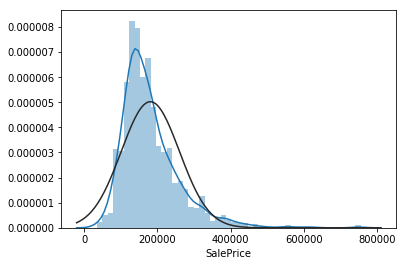

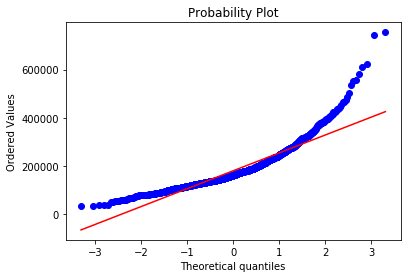

In [8]:
# Histogram and normal probability plot
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

In [9]:
# Skewness and Kurtosis
print("Skewness: ", train['SalePrice'].skew())
print("Kurtosis: ", train['SalePrice'].kurt())

Skewness:  1.8828757597682129
Kurtosis:  6.536281860064529


We see that the target variable SalePrice has a right-skewed distribution. Log transform appears to reduce the skewness. A normally distributed target variable helps in better modeling the relationship between target and independent variables.

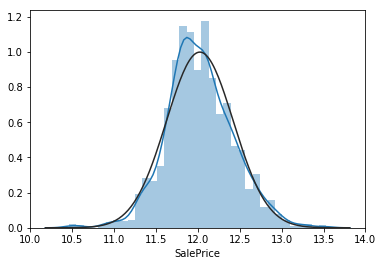

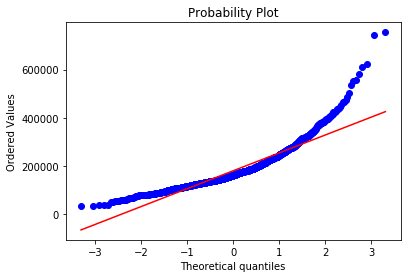

In [10]:
# Applying log transformation
sns.distplot(np.log(train['SalePrice']), fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

As we see above log transformation of the target variable hlped reduce skewed distribution and the new distribution looks closer to normal. 

### GrLivArea

In [11]:
# Descriptive statistics
train['GrLivArea'].describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

Next we look at the histogram to understand the distribution.

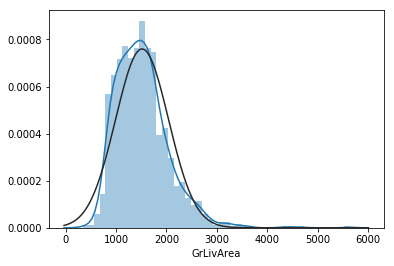

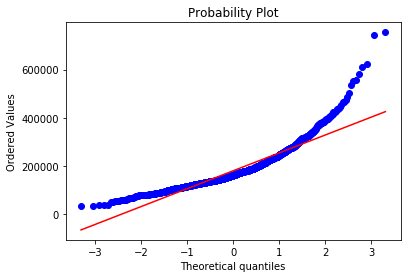

In [12]:
# Histogram and normal probability plot
sns.distplot(train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

### OverallQual

In [13]:
# Descriptive statistics
train['OverallQual'].describe()

count    1460.000000
mean        6.099315
std         1.382997
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64

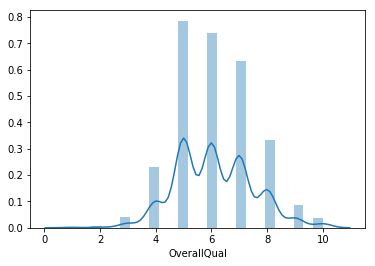

In [14]:
# Histogram
sns.distplot(train['OverallQual']);

As expected, the discrete nature of *OverallQual* feature shows multi-model histogram.

### YearBuilt

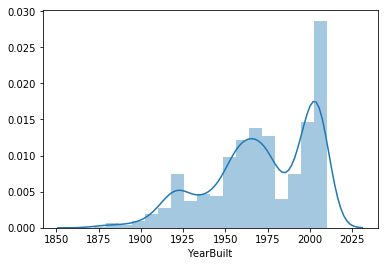

In [15]:
# Histogram
sns.distplot(train['YearBuilt']);

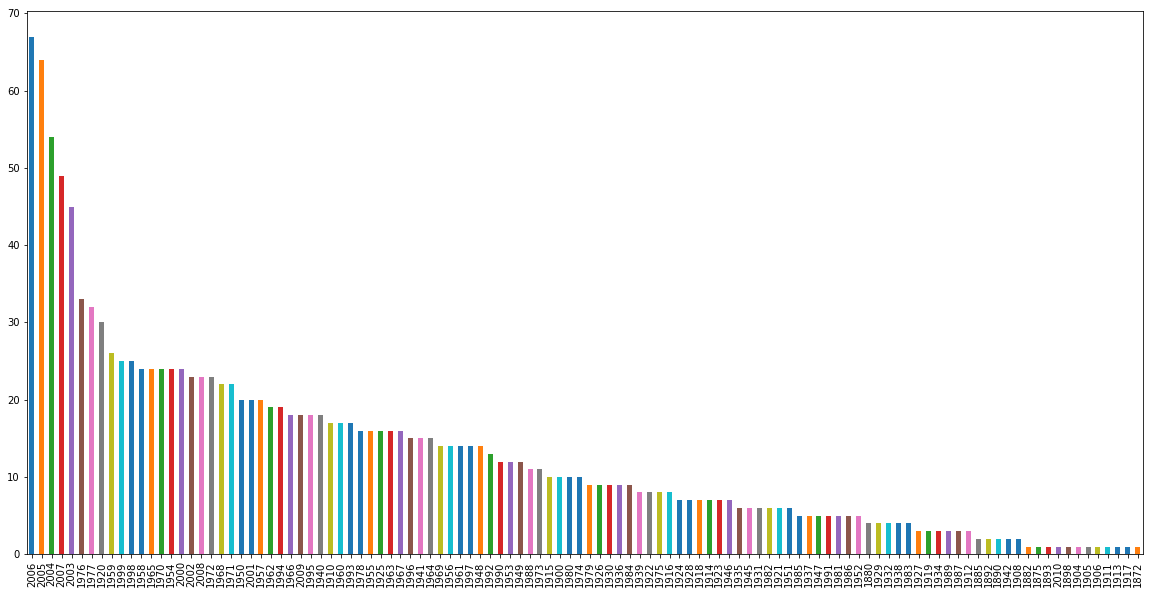

In [16]:
# Sorted in descending order
train['YearBuilt'].value_counts().plot(kind='bar', figsize=(20,10));

The year of house appears to follow power curve.

## Bivariate Analysis

In this section, we look at the relationship between target variable (SalePrice) and some other relevant features.  

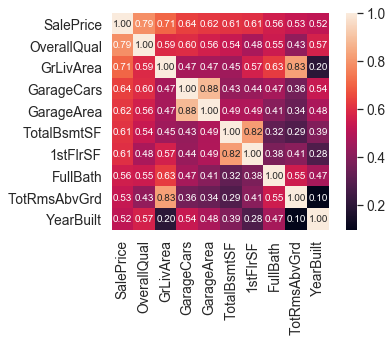

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64 

----------------------
ScreenPorch      0.111447
PoolArea         0.092404
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
OverallCond     -0.077856
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


In [17]:
# Correlation matrix showing evidence of multicollearity
# Remove Id column which is totally irrlevant
train_ = train.drop(['Id'], axis=1, errors='raise')
corrmat = train_.corr()
# Saleprice correlation matrix
k = 10 # number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
                 annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# let us print top correlated features (both positively and negatively) with SalePrice
corr_matrix = train_.corr()
print (corr_matrix['SalePrice'].sort_values(ascending=False)[:10], '\n') #top 10 values
print ('----------------------')
print (corr_matrix['SalePrice'].sort_values(ascending=False)[-10:]) #last 10 values`

From the collelation matrix (lighter color -> better correlation), some of the highly correlated features appears to be: *OverallQual*, *YearBuilt*, *YearRemodAdd*, *TotalBsmtSF*, *1stFlrSF*, *GrLivArea*, *FullBath*, *TotRmsAbvGrd*, *GarageCars*, and *GarageArea*.

As we can see, some variables seem to be strongly correlated with the target variable. Here we see that the OverallQual feature is 79% correlated with the target variable. Overallqual feature Rates the overall material and finish of the house. This seems to be the parameter that affects the sale price positively. In addition, GrLivArea is 70% correlated with the target variable. GrLivArea refers to the living area (in sq ft.) above ground.

### SalePrice - GrLivArea relationship

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


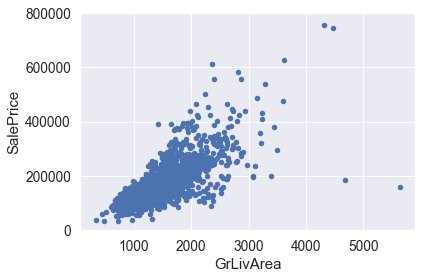

In [18]:
# Scatterplot of totalbsmtsf/saleprice
data = pd.concat([train['SalePrice'], train_['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000));

GrLivArea and SalePrice seem to have linear relationship of larger the area, higher the price. However, there a few observable outliers, though, on the higher extremes of areas.

### SalePrice - OverallQual relationship

Since OverallQual is a discrete variable, we look at the boxplots.

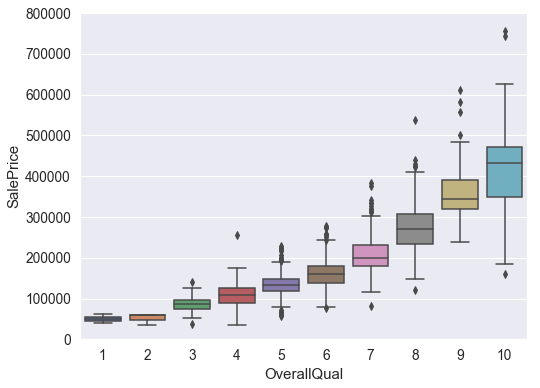

In [19]:
# Boxplot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train_[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

The boxplot shows strong relationship between overall quality of the house and its SalePrice.

### SalePrice - YearBuilt relationship

Again, boxplot also shows the general trend of higher price for newer house:

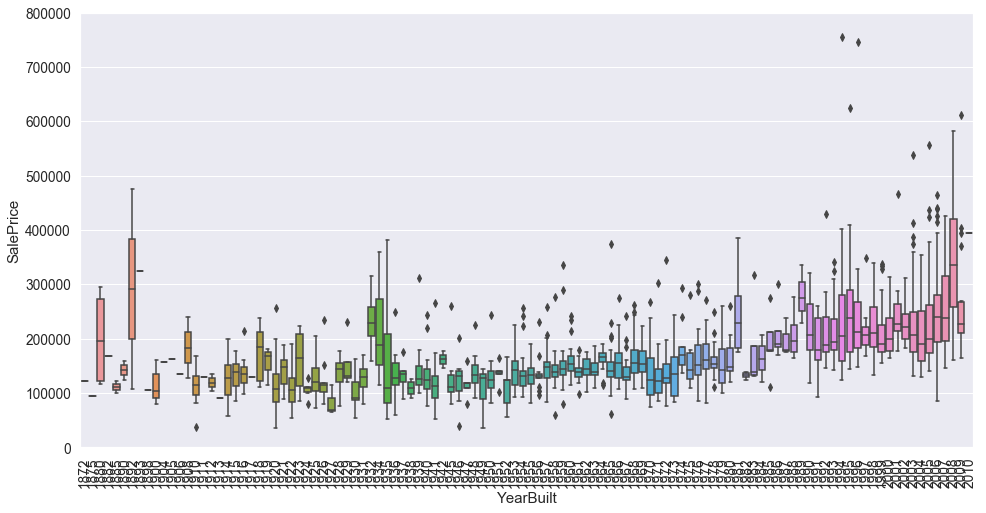

In [20]:
# Boxplot yearbuilt/saleprice
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train_[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=90);

### SalePrice - GarageCars relationship

The boxplot shows that there is linear relationship between size of garage and price when garage size is between 0 and 3. House with 4-car garage, though, doesn't appears to positively influence SalePrice.

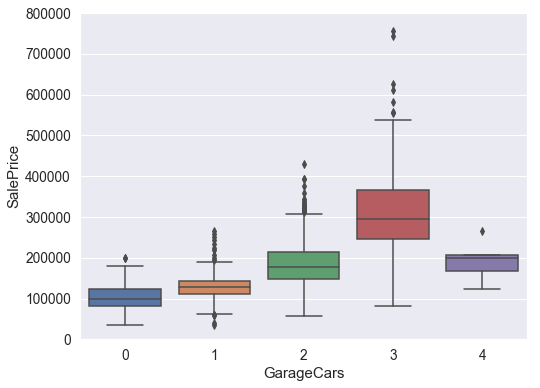

In [21]:
# Boxplot garagecars/saleprice
var = 'GarageCars'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

From the scatterplot of *SalePrice* vs the 10 picked variables, look like all demonstrate linear relationship with price.

# Feature Engineering

## Combine train and test data frames

We will combine train and test data frames so that all feature engineering changes are applied to both together.

In [22]:
# extract and keep the SalePrice (target) column.
y_train = train['SalePrice']
# drop SalePrice so that is has same cardinality as test dataframe
train.drop('SalePrice', axis=1, inplace=True)

# preseve test data set ids. we will need them for final prediction / submission
test_id = test.iloc[:,0]

# combine test and train
combined_df = pd.concat([train, test]).reset_index()
combined_df.shape

(2919, 81)

## Remove meaningless columns

In [23]:
# Id is not useful
combined_df.drop('Id', axis=1, inplace=True)
# Almost all rows has same value for Utilities, making this variable not useful
combined_df.drop('Utilities', axis=1, inplace=True)


## Missing Data Analysis

In this section, we will analyze missing values in the data set and approach to tackle these.

In [24]:
# Investigate about missing data.
# Analyze top 20 columns having missing data.
total = combined_df.isnull().sum().sort_values(ascending=False)
percent = (combined_df.isnull().sum() / combined_df.isnull().count() * 100).sort_values(ascending=False)
missing_data = pd.concat(
    [total, percent], axis=1, keys=["Total Number of Missing Data", "Missing Data Percentage"])
missing_data.head(20)

,Total Number of Missing Data,Missing Data Percentage
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
FireplaceQu,1420,48.646797
LotFrontage,486,16.649538
GarageCond,159,5.447071
GarageQual,159,5.447071
GarageYrBlt,159,5.447071
GarageFinish,159,5.447071


## Missing data handling

We decided to:
1. Drop columns with ~80% or more missing data


In [25]:
columns_will_be_removed = ['PoolQC', 'MiscFeature', 'Alley', 'Fence']

combined_df.drop(columns_will_be_removed, axis=1, inplace=True, errors='ignore')
combined_df.drop(columns_will_be_removed, axis=1, inplace=True, errors='ignore')

# Double check whether above columns are removed
total = combined_df.isnull().sum().sort_values(ascending=False)
percent = (combined_df.isnull().sum() / combined_df.isnull().count() * 100).sort_values(ascending=False)

def assert_column_drop(data, col_names):
    for col_name in col_names:
        assert col_name not in data, "%s should not exist" % col_name

In [26]:
print("Shape of data set after removing columns with 80% missing data: {}".format(combined_df.shape))

Shape of data set after removing columns with 80% missing data: (2919, 75)


## Missing values handling

1. From documentation: data_description.txt, the following column's default value (when NaN) is **None**.

In [27]:
default_none_columns = ['FireplaceQu', 'GarageType','GarageFinish','GarageQual',
                        'GarageCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
                        'MasVnrType']

for none_column in default_none_columns:
    combined_df[none_column].fillna('None', inplace = True)

2. From documentation: data_description.txt, the following column's default value (when NaN) is **0**. 

In [28]:
default_zero_columns = ['GarageYrBlt','GarageArea','GarageCars','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                        'TotalBsmtSF', 'BsmtFullBath','BsmtHalfBath','MasVnrArea']

for zero_column in default_zero_columns:
    combined_df[zero_column].fillna(0, inplace = True)

3. Using background knowledge, we set the missing value to the **mode** for some variables.

In [29]:
combined_df['Electrical'].fillna(combined_df['Electrical'].mode()[0], inplace=True)

4. LotFrontage: We will replace missing values with **mean** of the available data points for this column.

In [30]:
combined_df['LotFrontage'].fillna(combined_df['LotFrontage'].mean(), inplace=True)

5. We observed that values for some rows in the **test** data set has missing values (these columns do not have missing values in the train dataset). Missing values for these Categorical (Ordinal) type features: we will impute them with **mode** of the available values

In [31]:
combined_df['MSZoning'].fillna(combined_df['MSZoning'].mode()[0], inplace=True)
combined_df['Functional'].fillna(combined_df['Functional'].mode()[0], inplace=True)
combined_df['SaleType'].fillna(combined_df['SaleType'].mode()[0], inplace=True)
combined_df['KitchenQual'].fillna(combined_df['KitchenQual'].mode()[0], inplace=True)
combined_df['Exterior1st'].fillna(combined_df['Exterior1st'].mode()[0], inplace=True)
combined_df['Exterior2nd'].fillna(combined_df['Exterior2nd'].mode()[0], inplace=True)

Verify that there are no more missing values in the data set:

In [32]:
combined_df.isnull().sum().sum()

0

## Data Preparation

In this section, we will prepare data for machine learning modeling. This includes, preprocessing, transformations, encoding and scaling data.

### Log transformations

In [33]:
# as discussed in the EDA above, for SalePrice, we will perform log transformation
y_train = np.log(y_train)


We will also perform log transformation for these numeric features. Note that since the min value of PoolArea is 0, we cannot perform log transformation. We will, instead, use *log1p* transformation.

In [34]:
log_features = ['LotArea','PoolArea']

for log_feature in log_features:
    combined_df[log_feature] = np.log1p(combined_df[log_feature])

## Data Binning

1) To reduce side impact of filled data with default value, we dediced to bin year data into pre 1950, 1950 - 1974, 1975 - 2000, and post 2000 respectively. By this approach, if deafult value is filled by zero, it will be categorized in to pre-1950 instead of recognizing data itself as zero. We can assume that if data is missed, house data may not be recorded properly since it was built or remodeled before 1950.<br>
2) After binning, the targer column having continuous int value will be dropped.<br>
3) As a final step, value will be transformed into discrete value such as 1, 2, 3, or 4. Since recent update on the property can have a positive impact, larger value assigning for the recent years can be justfied.

In [35]:
PERIOD_TO_VALUE = {'0': 0, 'Before1950': 1, '1950to1974': 2, '1975to1999': 3, '2000OrLater': 4}
# Data Binning
# GarageYrBlt -> GarageBlt
combined_df.loc[(combined_df["GarageYrBlt"].apply(int) < 1950) & (combined_df["GarageYrBlt"].apply(int) >= 0), "GarageBlt"] = 'Before1950'
combined_df.loc[(combined_df["GarageYrBlt"].apply(int) < 1975) & (combined_df["GarageYrBlt"].apply(int) >= 1950), "GarageBlt"] = '1950to1974'
combined_df.loc[(combined_df["GarageYrBlt"].apply(int) < 2000) & (combined_df["GarageYrBlt"].apply(int) >= 1975), "GarageBlt"] = '1975to1999'
combined_df.loc[combined_df["GarageYrBlt"].apply(int) >= 2000, "GarageBlt"] = '2000OrLater'


# YearRemodAdd -> YrRemodeled
# Assume that there is no remodeling if built year == remodeled year.
combined_df.loc[combined_df["YearRemodAdd"] == combined_df["YearBuilt"], "YrRemodeled"] = 0
combined_df.loc[(combined_df["YearRemodAdd"] < 1950) & (combined_df["YearRemodAdd"] != 0), "YrRemodeled"] = 'Before1950'
combined_df.loc[(combined_df["YearRemodAdd"] < 1975) & (combined_df["YearRemodAdd"] >= 1950), "YrRemodeled"] = '1950to1974'
combined_df.loc[(combined_df["YearRemodAdd"] < 2000) & (combined_df["YearRemodAdd"] >= 1975), "YrRemodeled"] = '1975to1999'
combined_df.loc[combined_df["YearRemodAdd"] >= 2000, "YrRemodeled"] = '2000OrLater'



# YearBuilt -> YrBuilt
combined_df.loc[combined_df["YearBuilt"] < 1950, "YrBuilt"] = 'Before1950'
combined_df.loc[(combined_df["YearBuilt"] < 1975) & (combined_df["YearBuilt"] >= 1950), "YrBuilt"] = '1950to1974'
combined_df.loc[(combined_df["YearBuilt"] < 2000) & (combined_df["YearBuilt"] >= 1975), "YrBuilt"] = '1950to1974'
combined_df.loc[combined_df["YearBuilt"] >= 2000, "YrBuilt"] = '2000OrLater'



combined_df['GarageBlt'] = combined_df['GarageBlt'].apply(lambda period: PERIOD_TO_VALUE[period])
combined_df['YrRemodeled'] = combined_df['YrRemodeled'].apply(lambda period: PERIOD_TO_VALUE[period])
combined_df['YrBuilt'] = combined_df['YrBuilt'].apply(lambda period: PERIOD_TO_VALUE[period])

def get_distinct_values(values):
    return ",".join([str(i) for i in (set(values))])

# Check data binning results.
print("GarageBlt column values:", get_distinct_values(combined_df["GarageBlt"]))
print("YrRemodeled column values:", get_distinct_values(combined_df["YrRemodeled"]))
print("YrBuilt column values:", get_distinct_values(combined_df["YrBuilt"]))

GarageBlt column values: 1,2,3,4
YrRemodeled column values: 2,3,4
YrBuilt column values: 1,2,4


### Cleanup For Binning Applied Columns

In [36]:
# Drop columns after data binning. Continuous data is no longer meaningful.
combined_df.drop(['GarageYrBlt', 'YearRemodAdd', 'YearBuilt'], axis=1, inplace=True, errors='ignore')

## Categorical features : one hot encoding

In [37]:
combined_df = pd.get_dummies(combined_df)
combined_df.shape

(2919, 4694)

## Split back into train and test

In [38]:
X_train = combined_df[:train.shape[0]]
X_test = combined_df[train.shape[0]:]
X_train.shape,X_test.shape

((1460, 4694), (1459, 4694))

# Modeling

## Scaling features

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train, columns = combined_df.columns )

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = combined_df.columns)

## Create cross validation (Dev) data set for testing model performance

In [40]:
# Define cutoff to bisect train and cross validation data.
cutoff = (len(train) * 80) // 100

dev = X_train[cutoff:]
dev_labels = y_train[cutoff:]
x = X_train[:cutoff]
y = y_train[:cutoff]



In [41]:
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import time
res = defaultdict(dict)
def benchmark(model, name=None):
    if not name:
        name = model.__class__.__name__
    t0 = time.clock()
    model.fit(x, y)
    res[name]['train_time'] = time.clock() - t0
    t0 = time.clock()
    pred = model.predict(dev)
    res[name]['test_time'] = time.clock() - t0
    res[name]['rmse'] = np.sqrt(mean_squared_error(dev_labels, pred))
    return model

In [42]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV

In [43]:
benchmark(LinearRegression())
benchmark(Ridge(alpha=5.2))
benchmark(ElasticNet(alpha=0.01))
est = benchmark(GradientBoostingRegressor(learning_rate=0.1, n_estimators=200))
benchmark(RandomForestRegressor(n_estimators=30, max_depth=10))
res_df = pd.DataFrame(data=res).T
res_df[['train_time', 'test_time', 'rmse']]

,train_time,test_time,rmse
LinearRegression,4.944496,0.016283,0.179505
Ridge,0.416594,0.028386,0.178871
ElasticNet,1.643908,0.013697,0.187770
GradientBoostingRegressor,11.630032,0.013399,0.129898
RandomForestRegressor,2.152181,0.006350,0.145588


## Predict test and prepare submission

In [45]:
#y_test = np.exp(best_model.predict(X_test))
#pred_df = pd.DataFrame()
#pred_df['Id'] = test_id
#pred_df['SalePrice'] = y_test
#pred_df.to_csv('w207_mlaire.csv',index=False)

# TOBE MERGED

In [ ]:
def get_min_max_value(values):
    return (min(values), max(values))
print("min max values of log transformed SalePrice", get_min_max_value(y))
assert len(x.index) == cutoff # Confirm length is correct

# Remove SalePrice since it is y in the model.
#x.drop(['SalePrice'], axis=1, inplace=True, errors='ignore')
#dev.drop(['SalePrice'], axis=1, inplace=True, errors='ignore')

# Min-max scaling.
# (val - min) / (max - min), that all values will fit it in the range of [0, 1]
numerical_features = x.select_dtypes(exclude=['object']).columns
categorical_features = x.select_dtypes(include=["object"]).columns
discrete_features = []
for var in numerical_features:
    if len(train[var].unique()) < 20:
        discrete_features.append(var)
print('There are {} categorical variables; {} discrete variables out of {} total numeric vars.'
      .format(len(discrete_features), len(discrete_features), len(numerical_features)))

min_max_scaler = preprocessing.MinMaxScaler()
x_numerical_feature_scaled = min_max_scaler.fit_transform(x[numerical_features])
x[categorical_features]
x[discrete_features]

## Modeling

In this section, we plan to perform:
* Dimentionality reduction
* Building and tuning home prices prediction models

From 79 available features (input variables), we will use statistically and practically significant variables for modeling after data mangling. We also will try to watch out for collinearity and spurious relationships.  

We plan to start with LinearRegression model because of the predictive nature of the problem. We will also try other supervised learning models such as Random Forest and Gradient Boosting Tree if they increase accuracy.

We will be working on two broad sets of algorithms:
1. Linear Models
2. Non Linear relationships using Random Forests


We plan to begin with (multiple) LinearRegression model (for speed) and if the accuracy is not satisfactory, we would try other models such as random forest and gradient-boosting tree. If needed, we may have to ensemble all these models for better overall accuracy. We will split test data into two random sets and use one as "dev" data during model building process.

#### Linear Models
For linear models, we will try and test with the regular OLS model, and the regularized linear models of Ridge Regression, Least Absolute Shrinkage and Selection Operator (LASSO), and Elastic Net. 

For model tuning, Sklearn's grid search with CV function will be used to find the optimal hyper-parameter values.

To assess the predictive performance of regression models, we can compute the mean sum of squared errors and the related summary metric. Furthermore, we can also use graphical approach of residual plots to diagnose problems of linear regression models

We can apply regularization to our regression models to reduce the model complexity and avoid overfitting.

#### Non Linear relationships using Random Forests
For the decision tree algorithm, we will subdivide the input space into smaller regions so that it's more manageable. As Decision tree algorithm does not require any transformation of the features for nonlinear data, there will not be any feature transformation in this section. Since random forests are less sensitive to outliers in the dataset we are assuming at this point that it will not require much parameter tuning. The only parameter that will require experimenting might be number of trees. 

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
#from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV

In [ ]:
def rmse(predictions, targets):
    return np.sqrt(mean_squared_error(predictions,targets))

In [ ]:
## Fit lr using the train data and labels taken above, predict dev data.
lr = LinearRegression()
lr.fit(x, y)
prediction = lr.predict(dev_data)

## Distance of actuals vs predictors
accuracy = abs(prediction - dev_labels)

## Plots prediction vs actual sale price
f, ax = plt.subplots(figsize=(8, 6))
plt.scatter(prediction, dev_labels)
plt.title("Linear Regression")
plt.xlabel("Predicted Sale Price")
plt.ylabel("Actual Sale Price")
plt.show()

## Print out the mean accuracy, rmse, and lr score.
print("Mean accuracy %s \tRMSE %s \tRegression score %s" \
    %(accuracy.mean(), rmse(prediction, dev_labels), lr.score(dev_data, dev_labels)))

In [ ]:
N_FOLDS = 10

def rmsle_cv(model, x, test_labels):
    # KFold is for cross-validation
    kf = KFold(N_FOLDS, shuffle=True, random_state=0).get_n_splits(x)
    rsle = np.sqrt(-cross_val_score(model, x, test_labels, scoring="neg_mean_squared_error", cv=kf))
    return rsle.mean()

def lasso_fn(alphas):
    rmsle_list = []
    for i in alphas:
        lasso_reg = Lasso(alpha=i, normalize=True)
        rmsle_list.append(rmsle_cv(lasso_reg, x, y))

    plt.plot(alphas, rmsle_list)
    plt.xlabel("alpha")
    plt.ylabel("rmsle")
    plt.tick_params("L1 Lasso Model")

    print("The smallest rmsle by Lasso model is {:.4f}".format(min(rmsle_list)))
    print("This occurs when alpha is {}".format(alphas[np.argmin(rmsle_list)]))

    return alphas[np.argmin(rmsle_list)]

ALPHAS = [0.00001, 0.0001, 0.001, 0.005, 0.01, 0.05]
min_alpha_Lasso = lasso_fn(ALPHAS)

#### Lasso Result Analysis

The first model we ran is Linear regression with L1 Regularization which is known as Lasso Model. This model outputs a sparse matrix and has built-in feature selection due to the number of coefficients that return a value of zero.[1] We picked some alpha, then evaluate the different Lasso models using k fold cross-validation. We found the optimal alpha as 0.0001 for Lasso that has an average RMSLE of 0.1299. Please note that the higher alpha is, the more coefficients become zero.[2]

#### Grid Search CV

In [ ]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'EN': ElasticNet(),
    'RF': RandomForestRegressor(n_estimators=1000),
    'GBR': GradientBoostingRegressor(n_estimators=1000, loss='huber')
}

In [ ]:
params = {
    'LinearRegression': { },
    'Ridge': { 'alpha': [.001, 0.1, 1.0] },
    'Lasso': { 'alpha': [.001, 0.1, 1.0] },
    'EN': { 'alpha': [0.1, 1.0] },
    'RF': {'max_depth': [4,6],
            'min_samples_leaf': [3, 5, 9],
            'max_features': [1.0, 0.3, 0.1]},
    'GBR': {'learning_rate': [0.1, 0.05, 0.02],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5, 9],
              'max_features': [1.0, 0.3, 0.1]}
}

In [ ]:
def fit_gridcv(models,params,X,y,cv=3,n_jobs=1,verbose=1,scoring=None,refit=False):
    
    keys = models.keys()
    grid_searches = {}
    for key in keys:
        print("Running GridSearchCV for %s." % key)
        model = models[key]
        param_grid = params[key]
        grid_search = GridSearchCV(model, param_grid, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring, refit=refit)
        grid_search.fit(X,y)
        #print(gs.cv_results_)
        df0 = pd.DataFrame(grid_search.cv_results_)
        df =pd.DataFrame(grid_search.cv_results_)[['params','mean_train_score','mean_test_score']]
        df
        print(df)
        grid_searches[key] = grid_search
       
    #print(grid_searches)
   

In [ ]:
fit_gridcv(models,params,x,y,n_jobs=-1)

## Partial dependence

  * Relationship between the response and a set of features, marginalizing over all other features
  * Intuitively: expected response as a function of the features we conditioned on

In [ ]:
FIGSIZE = (11,7)
type(est.feature_importances_)
fx_imp = pd.Series(est.feature_importances_, index=features)
fx_imp /= fx_imp.max()  # normalize
#fx_imp.sort()
fx_imp.nlargest(20).plot(kind='barh', figsize=FIGSIZE)

## Partial dependence

  * Relationship between the response and a set of features, marginalizing over all other features
  * Intuitively: expected response as a function of the features we conditioned on

In [ ]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
features = ['MasVnrArea', 'MoSold', 'MiscVal', 'FullBath', 'SaleCondition_Family','OpenPorchSF', '2ndFlrSF', 'EnclosedPorch',
           'WoodDeckSF','TotalBsmtSF_Log']
fig, axs = plot_partial_dependence(est, X_train_data, features, feature_names=features, 
                                   n_cols=6, figsize=(20,15))

## Summary & Key Results

In this section, we will present our key findings in terms of key predictor variables and their parameter values. We will also summary the modeling process and learning from it.

## References

[1]: <a href="https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c">L1 and L2 Regulazation Model</a><br>
[2]: <a href="https://chrisalbon.com/machine_learning/linear_regression/effect_of_alpha_on_lasso_regression/">Effect of Alpha on Lasso Regression</a><br>